<a href="https://colab.research.google.com/github/uteyechea/DCGAN-Faces-Generator/blob/main/cifar10_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional Generative Adversarial Network

### Setup

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

# Display info about the CPU the notebook is running on
!apt-get install inxi &> /dev/null
!inxi -C 

# Display info about the GPU the notebook is running on
!echo -e "\e[34mGPU: \e[39m"
!apt-get install clinfo &> /dev/null
!lspci | grep -i nvidia
!clinfo | head -n18

CPU:       Single core Intel Xeon (-MT-) cache: 56320 KB
           clock speeds: max: 2199 MHz 1: 2199 MHz 2: 2199 MHz
GPU: 
00:04.0 3D controller: NVIDIA Corporation Device 1eb8 (rev a1)
Number of platforms                               1
  Platform Name                                   NVIDIA CUDA
  Platform Vendor                                 NVIDIA Corporation
  Platform Version                                OpenCL 1.2 CUDA 11.2.109
  Platform Profile                                FULL_PROFILE
  Platform Extensions                             cl_khr_global_int32_base_atomics cl_khr_global_int32_extended_atomics cl_khr_local_int32_base_atomics cl_khr_local_int32_extended_atomics cl_khr_fp64 cl_khr_byte_addressable_store cl_khr_icd cl_nv_compiler_options cl_nv_device_attribute_query cl_nv_pragma_unroll cl_nv_copy_opts cl_nv_create_buffer cl_khr_int64_base_atomics cl_khr_int64_extended_atomics cl_nv_kernel_attribute cl_khr_device_uuid
  Platform Extensions function suffix      

In [31]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-63rjgtog
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-63rjgtog
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0a9cbc44121628a60850bb9388282167a93ed26ff_-cp37-none-any.whl size=147327 sha256=f0185837822e437df60d845b500bd4ac96a36af63a32341d50d0bc1b8a9d1c15
  Stored in directory: /tmp/pip-ephem-wheel-cache-e7ydizh0/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
import pathlib

### Connect Google Drive and explore the dataset



In [5]:
"""
#Mount my Google Drive 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#Define global path to working directory
data_dir='/content/drive/MyDrive/Colab Notebooks/DCGAN/'
#Create pathlib object
data_dir = pathlib.Path(data_dir)
"""


"\n#Mount my Google Drive \nfrom google.colab import drive\ndrive.mount('/content/drive', force_remount=True)\n\n#Define global path to working directory\ndata_dir='/content/drive/MyDrive/Colab Notebooks/DCGAN/'\n#Create pathlib object\ndata_dir = pathlib.Path(data_dir)\n"

### Load and prepare the dataset

You will use the CIFAR10 dataset to train the generator and the discriminator. The generator will generate pictures resembling the 10 classes in the data.

In [6]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()
#(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data() # Fashion accesories kerasdataset
#(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() #handwriten digits dataset

170500096/170498071 [==============================] - 3s 0us/step


In [7]:
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [8]:
BUFFER_SIZE = train_images.shape[0]
IMG_LENGTH = train_images.shape[1] #Must be a multiple of 4
assert IMG_LENGTH % 4 == 0
IMG_WIDTH = train_images.shape[2] #Must be a multiple of 4
assert IMG_WIDTH % 4 == 0
CHANNELS = train_images.shape[3]
BATCH_SIZE = 256

IMG_SIZE=IMG_LENGTH*IMG_WIDTH*CHANNELS

In [9]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

###Visualize a sample from the dataset


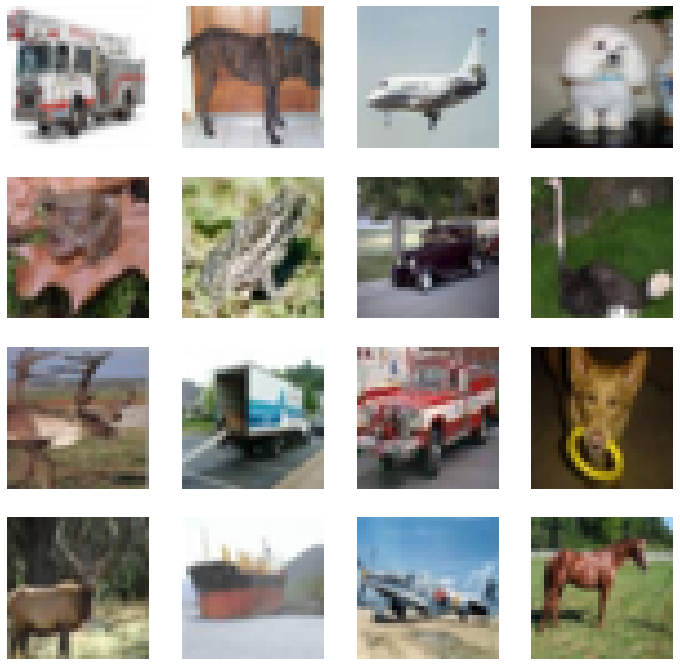

In [10]:
plt.figure(figsize=(12, 12))
for images in train_dataset.take(1): #take(): Creates a Dataset with at most count elements from this dataset.
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow((images[i].numpy()*127.5+127.5).astype('int'))
    plt.axis("off")

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 32x32x3. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

Observations:

1. Starting from 512 improves resolution, but it does not finish training.

2. 

In [11]:
def make_generator_model(img_length=IMG_LENGTH,img_width=IMG_WIDTH,channels=CHANNELS):
    model = tf.keras.Sequential()
    model.add(layers.Dense(img_length//4*img_width//4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((img_length//4, img_width//4, 256)))
    assert model.output_shape == (None, img_length//4, img_width//4, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (1, 1), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, img_length//4, img_width//4, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, img_length//2, img_width//2, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, img_length, img_width, channels)

    return model

Use the (as yet untrained) generator to create an image.

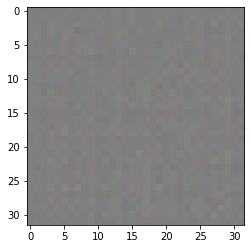

In [12]:
generator = make_generator_model()

#noise = tf.random.uniform([1, 100],minval=-1,maxval=1)
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)

plt.imshow((generated_image[0].numpy()*127.5+127.5).astype('int'))

### The Discriminator

The discriminator is a CNN-based image classifier.

Observations:
1. Filters and kernel size follow an inverse proportional relationship. Or remain constant.

2. A change in strides does not impact much the generated output.

3. Does the number of layers impact performance and output quality? an increase in the number of layers, decreases performance. The output image is better defined, as if it has a better control over the distribution of pixels.

4. Does the droput rate increase image quality? (droput rate could correlate with decreased creativity vs increased fidelity.)

In [13]:
def make_discriminator_model(img_length=IMG_LENGTH, img_width=IMG_WIDTH, channels=CHANNELS):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[img_length, img_width, channels]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(256, (1, 1), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    #Takes around 40s / iteration.
    #model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    #model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00010333]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [15]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [19]:
#checkpoint_dir = os.path.join(data_dir,'training_checkpoints')
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [20]:
EPOCHS = 300
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [21]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss,disc_loss

In [22]:
history = []

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)

    # Update the progress bar
    history.append([gen_loss.numpy().mean(),disc_loss.numpy().mean()])

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    # Visualize Generator & Discriminator Loss
    plotter(history,epoch)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  plotter(history,epoch)

**Train loss plotter**

In [23]:
def plotter(history,epoch):

  x=np.arange(len(history))
  history=np.array(history)
  gen_loss = history[:,0]
  disc_loss = history[:,1]

  plt.figure(figsize=(10, 4)) 
  plt.title('Generator & Discriminator Loss')
  
  plt.subplot(1, 2, 1)
  plt.plot(x, gen_loss, label='Generator Loss')
  plt.legend(loc='lower left')

  plt.subplot(1, 2, 2)
  plt.plot(x, disc_loss, label='Discriminator Loss')
  plt.legend(loc='lower left')

  plt.show()

**Generate and save images**


In [24]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i].numpy()*127.5+127.5).astype('int') )
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated images will look increasingly real. After about n epochs, they resemble something real. 

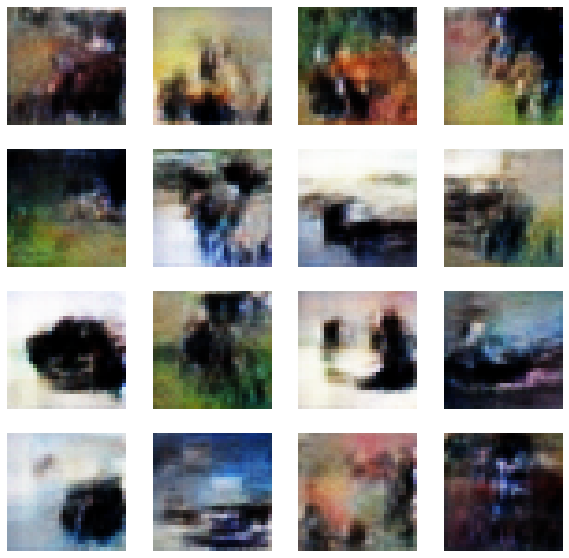

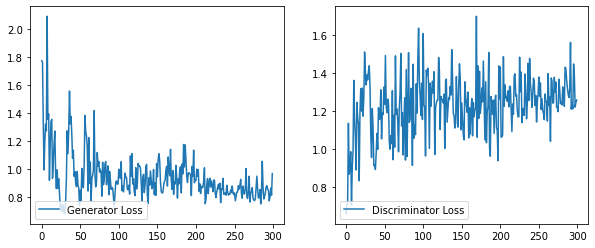

In [25]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [26]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [27]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

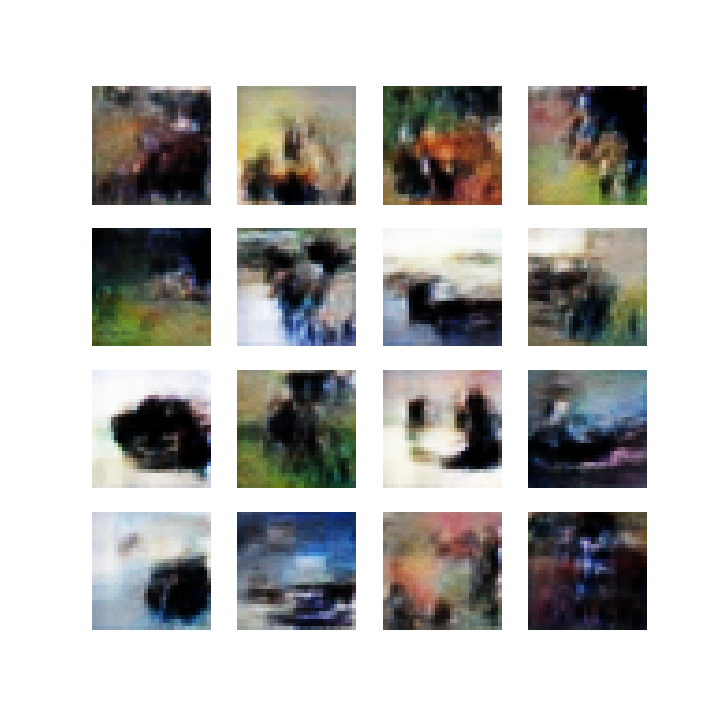

In [28]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [32]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [33]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)